In [4]:
import numpy as np
import torch 
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt

## Diffusion Model for Image Generation

In this notebook, I work through DeepFindr's diffusion model from his video https://www.youtube.com/watch?v=a4Yfz2FxXiY. I apply his simplified U-Net architecture to the Flowers102 dataset from torchvisions database. I make changes and adjustments to the code to suit my personal preferences, and add notes to myself within cells explaining the code. The purpose of this notebook is firstly to become familiar with the PyTorch library and its various functions and methods, and secondly to gain a practical understanding of diffusion models for use in image generation.
After 90 epochs of backpropogation, this is an example of a generated image:
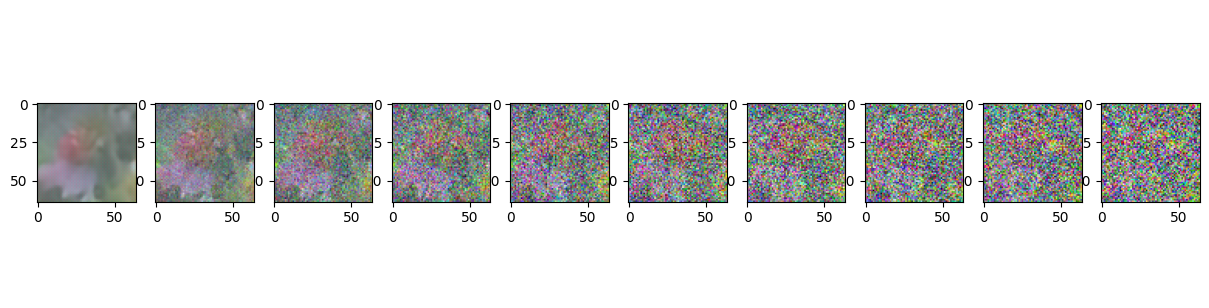

As in DeepFindr's video, this is a simplified model based on the model proposed in the DDPM paper: https://arxiv.org/pdf/2006.11239

Some other useful rescources: https://medium.com/@staytechrich/understanding-and-implementing-diffusion-models-8ad23e828f0a, https://amaarora.github.io/posts/2020-09-13-unet.html



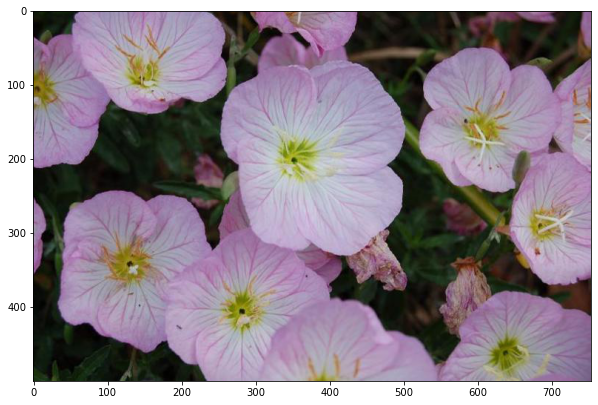

In [5]:
# initialising data set
data = torchvision.datasets.Flowers102(root=".", download=True)

# each data point is of the form (PIL image, batch no.)

plt.figure(figsize=(10,10)) 
plt.imshow(data[0][0])

In [6]:
from torchvision import transforms 

IMG_SIZE = 64
BATCH_SIZE = 128

'''
here we apply a series of transformations to the images. These transformations include resizing images to IMG_SIZE 
(64x64 pixels), randomly flipping them horizontally for data augmentation, converting them into PyTorch tensors, 
and normalizing their pixel values to the range [-1, 1].
We then split the data into trian and test, and initialise data, a torch.utils.data.ConcatDataset object, which combines
the training and test splits of the dataset into a single dataset with these transformations applied.
'''

data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # Scales data into [0,1] 
        transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1] 
    ]
data_transform = transforms.Compose(data_transforms)

train = torchvision.datasets.Flowers102(root=".", download=True, 
                                         transform=data_transform)
test = torchvision.datasets.Flowers102(root=".", download=True, 
                                         transform=data_transform, split='test')

data = torch.utils.data.ConcatDataset([train, test])

# utilising DataLoader to yeild batches of 128 (BATCH_SIZE) samples at a time, ready for gradient descent algorithm
from torch.utils.data import DataLoader
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

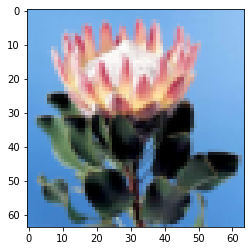

In [7]:
def show_tensor_image(image):
    
    '''
    This function takes a tensor image (or batch of images) from our transformed dataset (data), 
    reverses the transformations, and converts the tensor back into a PIL image.
    '''
    
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # take the first image of batch of images
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    plt.imshow(reverse_transforms(image))
    
show_tensor_image(data[127][0])

In [8]:

# defining the linear beta schedule
T=300
timesteps=T
start = 0.0001
end = 0.02
β = torch.linspace(start, end, T)

#calculating alpha and its cumulative product alpha_bar, and some other lists of quantities used later

α = 1. - β
α_bar = torch.cumprod(α, dim=0)
sqrt_α_bar = torch.sqrt(α_bar)
sqrt_1_minus_α_bar = torch.sqrt(1.- α_bar)

# σ is the sqrt of the posterior variance
σ = torch.zeros_like(β)
σ[0] = 0 
for t in range(1, len(β)):
    σ[t] = torch.sqrt( β[t] * (1 - α_bar[t-1]) / (1 - α_bar[t]) )


In [9]:
def get_index_from_list(vals, t, x_shape):
    """
    The get_index_from_list function is a function used to retrieve values from a list or tensor (vals) 
    at specified indices (t), while correctly handling batch dimensions and ensuring the output tensor is on 
    the correct device:
    
    explanation of variables:
    vals: This is the list or tensor from which you want to retrieve values. In the context of the diffusion model, 
    this usually holds pre-calculated terms like betas or sqrt_alphas_cumprod.
    
    t: This is a tensor of indices. Crucially, it's expected to be a batch of timesteps, meaning it has a batch_size 
    dimension.
    
    x_shape: This is the shape of the original input data (e.g., an image batch (batch_size, channels, height, width)). 
    It's used to correctly reshape the output so it can be broadcasted across the other dimensions of x_0.
    
    
    batch_size = t.shape[0]: Extracts the batch size from the t (timesteps) tensor.
    

    out = vals.gather(-1, t.cpu()):

    t.cpu(): Moves the t tensor to the CPU for the gather operation. This is often done to ensure compatibility if vals 
    is on the CPU or if gather has specific device requirements.
    
    vals.gather(-1, ...): This is a PyTorch function that gathers values along a specified dimension. Here, -1 means it 
    gathers along the last dimension of vals (which for 1D vals means the only dimension), using the indices provided by
    t. The result out will have the same shape as t, containing the values from vals at the corresponding t indices.
    
    
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device):

    reshape(batch_size, *((1,) * (len(x_shape) - 1))): This reshapes the out tensor. It keeps the batch_size dimension, and
    then adds len(x_shape) - 1 singleton dimensions (dimensions of size 1). For example, if x_shape 
    is (batch_size, 3, 64, 64), len(x_shape) is 4, so len(x_shape) - 1 is 3. The out tensor will be reshaped 
    to (batch_size, 1, 1, 1). This is essential for broadcasting the value (e.g., a specific sqrt_alphas_cumprod_t) across 
    all channels, height, and width of an image in the batch.
    Also, the .to(t.device): Moves the reshaped tensor back to the device where the original t tensor resided
    (e.g., 'cuda' if t was on the GPU). This ensures consistency for subsequent tensor operations.
    """
    
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [10]:
def noise_image(x, t, device="cpu"):
    sqrt_α_bar_t = get_index_from_list(sqrt_α_bar, t, x.shape)
    sqrt_1_minus_α_bar_t = get_index_from_list(sqrt_1_minus_α_bar, t, x.shape)
    
    ϵ = torch.randn_like(x)
    return sqrt_α_bar_t.to(device) * x.to(device) \
    + sqrt_1_minus_α_bar_t.to(device) * ϵ.to(device), ϵ.to(device)

In [26]:
from torch import nn
import math

  
'''
The U-Net neural network will have shared parameters across time - meaning, for an input (x, t) into our U-Net, the
same neural network is used to predict the noise added to the image (x) independent of the timestep (t). To overcome this,
we introduce a sinusoidal positional embedding function, with parameter dimension = dim, which takes in a time 
(or batch of times) t (rank-1 tensor) and outputs a vector of dimension dim.
    
Thus the U-Net is capable of predicting the noise in images with varying levels of noise.
'''
    

class SinusoidalPositionEmbeddings(nn.Module):
    
    '''
    We define a class SinusoidalPositionEmbeddings inheriting the parent class nn.Module as follows:
    '''
  
    def __init__(self, dim):
        '''
        The constructor takes one argument: dim. This dim represents the desired dimensionality of the output embeddings. 
        For example, if dim is 32, each timestep will be embedded into a 32-dimensional vector.
    
        super().__init__(): Calls the constructor of the parent class nn.Module.
        '''
        super().__init__()
        self.dim = dim

    def forward(self, time):
        '''
        The forward function takes in one variable (time) a rank-1 tensor [t_1, t_2, ..., t_n], which typically 
        contains the current timestep(s) for the batch.
        
        device = time.device: Gets the device (CPU or GPU) where the input time tensor resides, ensuring subsequent
        tensor operations happen on the same device.
        
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings) creates a set of exponentially
        decreasing frequencies.
        
        embeddings = time[:, None] * embeddings[None, :]: This performs an outer product.
        time[:, None] reshapes the time tensor to have an extra dimension, e.g., if time is [t1, t2, ..., tn], it becomes
        [[t1], [t2], ..., [tn]].
        embeddings[None, :] reshapes the frequency embeddings to have an extra dimension at the beginning, 
        e.g., [freq1, freq2, ..., freq_half_dim] becomes [[freq1, freq2, ..., freq_half_dim]].
        Multiplying these two results in a rank-2 tensor (matrix) where each row corresponds to a timestep, and each column
        corresponds to a frequency, essentially: a_i,j = time_i * frequency_j.
        
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1): Finally, the sine and cosine of these scaled 
        time-frequency products are computed and concatenated along the last dimension.
        '''
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        
        return embeddings
    
# for example:
SinusoidalPositionEmbeddings(dim=32)(torch.tensor([1])), SinusoidalPositionEmbeddings(dim=32)(torch.tensor([1,2]))

(tensor([[8.4147e-01, 5.1514e-01, 2.8870e-01, 1.5783e-01, 8.5664e-02, 4.6399e-02,
          2.5116e-02, 1.3593e-02, 7.3564e-03, 3.9811e-03, 2.1544e-03, 1.1659e-03,
          6.3096e-04, 3.4146e-04, 1.8479e-04, 1.0000e-04, 5.4030e-01, 8.5711e-01,
          9.5742e-01, 9.8747e-01, 9.9632e-01, 9.9892e-01, 9.9968e-01, 9.9991e-01,
          9.9997e-01, 9.9999e-01, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
          1.0000e+00, 1.0000e+00]]),
 tensor([[ 8.4147e-01,  5.1514e-01,  2.8870e-01,  1.5783e-01,  8.5664e-02,
           4.6399e-02,  2.5116e-02,  1.3593e-02,  7.3564e-03,  3.9811e-03,
           2.1544e-03,  1.1659e-03,  6.3096e-04,  3.4146e-04,  1.8479e-04,
           1.0000e-04,  5.4030e-01,  8.5711e-01,  9.5742e-01,  9.8747e-01,
           9.9632e-01,  9.9892e-01,  9.9968e-01,  9.9991e-01,  9.9997e-01,
           9.9999e-01,  1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,
           1.0000e+00,  1.0000e+00],
         [ 9.0930e-01,  8.8306e-01,  5.5281e-01,  3.1170e-01,  1.7

In [9]:

# defining the encoder blocks

class enc_block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super().__init__()
        '''
        super().__init__(): Calls the constructor of the parent class nn.Module.
        '''
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)
    
# defining the decoder blocks

class dec_block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super().__init__()
    
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        
        self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
        self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)

In [10]:

class UNet(nn.Module):
   
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 3 
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([enc_block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([dec_block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim) \
                    for i in range(len(up_channels)-1)])
        
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)

model = UNet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  62438883


UNet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): enc_block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): enc_block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transf

In [11]:

# defining loss function

def loss_function(model, x, t):
    x_noised, noise = noise_image(x, t, device)
    noise_pred = model(x_noised, t)
    return F.l1_loss(noise, noise_pred)

In [12]:
@torch.no_grad()
def denoise_image(x_t_plus_1, t):
    
    """
    takes the tensor image x_(t+1) and the timestep t (rank-1 tensor of dimension 1) and returns 
    the denoised tensor image x_t, and adds noise if t not equal to zero
    
    """
    x_t = (1/torch.sqrt(α[t])) * (
                    x_t_plus_1 - β[t] * model(x_t_plus_1, t) / sqrt_1_minus_α_bar[t])

    if t == 0:
        return x_t
    else:
        ϵ = torch.randn_like(x_t_plus_1)
        return x_t + σ[t] * ϵ

@torch.no_grad()
def sample_plot_image():
    
    '''
    This function takes a single (batch size of 1) tensor image x from a normal gaussian distribution and uses
    the previously defined denoise_image function to iteratively denoise the image over T=300 iterations. It then
    plots the tensor image using the previously defined show_tensor_image function.
    '''
    
    x = torch.randn((1, 3, IMG_SIZE, IMG_SIZE), device=device)
    plt.figure(figsize=(5,5))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]: #iterates through sequence of integers from T-1 down to 0 in reverse order
        
        t = torch.full((1,), i, device=device, dtype=torch.long)
        x = denoise_image(x, t)
        x = torch.clamp(x, -1.0, 1.0)
        if i == 0:
            show_tensor_image(x.detach().cpu())
    plt.show()     

Epoch 0, Loss: 0.810319721698761 


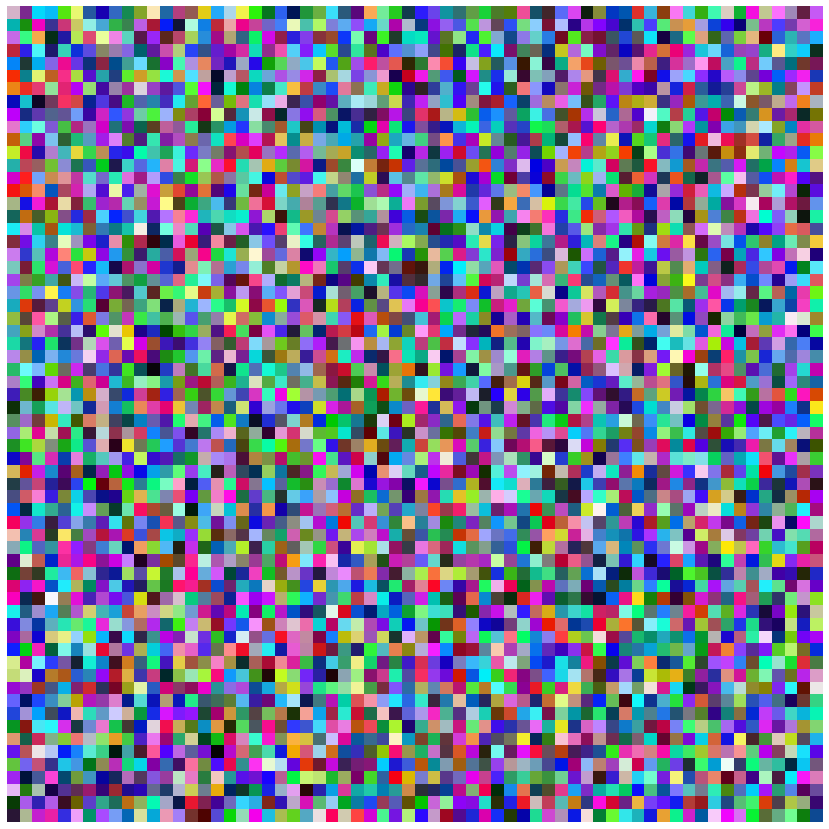

In [ ]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 100 

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
      loss = loss_function(model, batch[0], t)
      loss.backward()
      optimizer.step()
    
    #show result of sampled image after every 5 iterations of backpropogation, along with current loss

      if epoch % 5 == 0 and step == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()} ")
        sample_plot_image()